In [1]:
import sklearn
sklearn.__version__
# 0.22.2.post1
import mglearn
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import MinMaxScaler

## 6.5 전처리와 모델의 매개변수를 위한 그리드 서치

* 파이프라인을 사용하면 머신러닝 워크플로에 필요한 모든 처리 단계를 하나의 scikit-learn 추정기로 캡슐화할 수 있다.  
* 회귀와 분류 같은 지도 학습의 출력을 이용해서 전처리 매개 변수를 조정할 수 있다. 
* boston 데이터 셋에서 파이프라인을 사용해 리지 회귀에 적용
* 이 파이프라인은 데이터 스케일 조정, 다항식 특성 선택, 리지 회귀의 세 단계로 구성

In [2]:
from sklearn.datasets import load_boston

boston=load_boston()
X_train,X_test,y_train,y_test=train_test_split(boston.data,boston.target,random_state=0)

from sklearn.preprocessing import PolynomialFeatures
pipe=make_pipeline(StandardScaler(),PolynomialFeatures(),Ridge())

* 분류의 결과에 기초해서 degree 매개 변수를 선택하는 것이 이상적이다.
* 파이프라인을 사용하면 Ridge의 alpha 매개변수와 함께 degree 매개 변수를 탐색할 수 있다.  
이를 위해서는 단계의 이름을 접두어로 사용한 매개변수 두 개를 param_grid에 정의해야 한다.  

In [3]:
param_grid={'polynomialfeatures__degree':[1,2,3],
           'ridge__alpha':[0.001,0.01,0.1,1,10,100]}

* 그런 다음 그리드 서치를 적용

In [4]:
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('ridge', Ridge())]),
             n_jobs=-1,
             param_grid={'polynomialfeatures__degree': [1, 2, 3],
                         'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]})

* 교차 검증의 결과를 히트맵을 사용해서 나타내면,

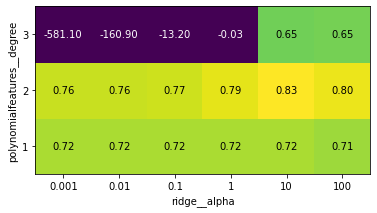

In [5]:
mglearn.tools.heatmap(grid.cv_results_['mean_test_score'].reshape(3,-1),
               xlabel="ridge__alpha",ylabel="polynomialfeatures__degree",
               xticklabels=param_grid['ridge__alpha'],
               yticklabels=param_grid['polynomialfeatures__degree'],vmin=0)

* 교차 검증의 결과를 보면 2차항이 효과가 좋고 3차항은 1, 2차보다 결과가 나쁘다.
* 최적의 매개변수 확인해서도 알 수 있다.

In [6]:
print("최적의 매개변수:",grid.best_params_)

최적의 매개변수: {'polynomialfeatures__degree': 2, 'ridge__alpha': 10}


* 테스트 점수를 확인해 보면,

In [7]:
print("테스트 점수: {:.2f}".format(grid.score(X_test,y_test)))

테스트 점수: 0.77


* 다항식 특성이 없는 그리드 서치와 비교해 보면,

In [8]:
param_grid={'ridge__alpha': [0.001,0.01,0.1,1,10,100]}
pipe=make_pipeline(StandardScaler(),Ridge())
grid=GridSearchCV(pipe,param_grid,cv=5)
grid.fit(X_train,y_train)
print("다항 특성이 없을 때 점수: {:.2f}".format(grid.score(X_test,y_test)))

다항 특성이 없을 때 점수: 0.63


* 다항 특성이 없는 경우 성능이 낮아짐

* 모델의 매개변수와 함께 전처리 과정의 매개변수를 찾는 것은 매우 강력한 전략
* GridSearchCV는 지정한 매개변수의 모든 가능한 조합을 시도, 따라서 매개 변수   
그리드에 많은 매개 변수를 추가하면 만들어야 할 모델이 급격히 증가

## 6.6 모델 선택을 위한 그리드 서치
* GridSearchCV와 Pipeline을 연결하는 것에서 더 나아가, 파이프 라인을 구성하는 단계도 탐색 대상으로 삼을 수 있다.
* 이렇게 하면 탐색 범위가 더 넓어지므로 주의 깊게 고려해야 한다.
* 모든 알고리즘을 시도해보는 것이 필수적인 머신러닝 전략은 아니다.
* cancer 데이터 셋에서 RandomForestClassifier와 SVC를 비교
* SVC는 데이터의 스케일을 조정해야 하므로 StandardScaler를 사용할지 또는 전처리를 하지 않을지 판단이 필요
* RandomForestClassifier에는 전처리가 필요 없다.

* 먼저 파이프라인 정의, 여기서는 단계 이름을 직접 지정한다.
* 단계는 두개가 필요하며, 하나는 전처리이고, 다른 하나는 분류기이다. 
* SVC와 StandardScaler를 사용해 파이프라인 객체를 만든다.

In [9]:
from sklearn.svm import SVC
pipe=Pipeline([('preprocessing',StandardScaler()),('classifier',SVC())])

* 검색할 parameter_grid를 정의.
* classifier는 RandomForestClassifier나 SVC가 되어야 한다. 
* 두 모델의 매개변수와 전처리가 다르므로 매개변수 그리드의 리스트를 사용한다.
* 어떤 추정기에 해당하는 단계인지 지정하려면 추정기 단계의 이름을 매개변수 이름으로 사용
* 파이프 라인의 단계를 건너 뛰어야 할때는 단계에 None을 할당.

In [10]:
from sklearn.ensemble import RandomForestClassifier

param_grid = [
    {'classifier': [SVC()], 'preprocessing': [StandardScaler()],
     'classifier__gamma': [0.001, 0.01, 0.1, 1, 10, 100],
     'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]},
    {'classifier': [RandomForestClassifier(n_estimators=100)],
     'preprocessing': [None], 'classifier__max_features': [1, 2, 3]}]

* 그리드 서치 객체를 만들고 cancer 데이터 셋으로 진행

In [11]:
cancer=load_breast_cancer()
X_train,X_test,y_train,y_test=train_test_split(cancer.data,cancer.target,random_state=0)
grid=GridSearchCV(pipe,param_grid,cv=5)
grid.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing', StandardScaler()),
                                       ('classifier', SVC())]),
             param_grid=[{'classifier': [SVC(C=10, gamma=0.01)],
                          'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
                          'classifier__gamma': [0.001, 0.01, 0.1, 1, 10, 100],
                          'preprocessing': [StandardScaler()]},
                         {'classifier': [RandomForestClassifier()],
                          'classifier__max_features': [1, 2, 3],
                          'preprocessing': [None]}])

In [12]:
print("최적의 매개변수:\n{}\n".format(grid.best_params_))
print("최상의 교차 검증 점수: {:.2f}".format(grid.best_score_))
print("테스트 세트 점수: {:.2f}".format(grid.score(X_test,y_test)))

최적의 매개변수:
{'classifier': SVC(C=10, gamma=0.01), 'classifier__C': 10, 'classifier__gamma': 0.01, 'preprocessing': StandardScaler()}

최상의 교차 검증 점수: 0.99
테스트 세트 점수: 0.98


* 그리드 서치의 결과는 StandardScaler 전처리를 사요하고 C=10, gamma=0.01인 SVC에서 최상의 결과를 얻었습니다.

### 6.6.1 중복계산 피하기

* 대규모 그리드 서치를 수행할 때 종종 동일한 단계가 여러번 수행된다.
* 간단한 해결책은 파이프라인의 memory 매개 변수를 사용하여 계산 결과를 캐싱하는 것이다.
* 이 매개변수는 joblib.Memory 객체나 캐싱할 경로를 받습니다. 
* 다음처럼 간단히 캐싱을 활성화할 수도 있다.

In [13]:
pipe=Pipeline([('preprocessing',StandardScaler()),('classifier',SVC())],memory="cache_folder")

#### 첫번째 단점
* 캐시는 디스크에 저장되어 관리되기 때문에 실제 디스크에 읽고 쓰기 위해 직렬화가 필요하다. 따라서 비교적 오랜 시간이 걸리는 변환이어야 memory 매개변수를 사용하여 속도를 높이는 효과를 낼 수 있다.
* 단순히 데이터의 스케일을 변환하는 것이라면 스케일 조정된 데이터를 디스크에서 읽는 것 보다 빠를 가능성이 높다.
* 계산 비용이 높은 변환이라면 그래도 여전히 유용하다.  

#### 두번째 단점
* n_jobs 배개변수가 캐싱을 방해한다는 것이다. 그리드 서치의 실행 순서에 따라 최악의 경우 캐시되기 전에 n_jobs만큼의 작업 프로세스가 동시에 동일한 계산을 중복으로 수행할 수 있다.



* dask-ml 라이브러리에서 제공하는 GridSearchCV를 사용하면 이런 단점을 모두 피할 수 있다. dask-ml은 병렬 연산을 수행하는 동안 중복된 계산을 방지한다. 
* 클러스터에 분산된 경우에도 가능하다.
* 따라서 계산 비용이 높은 파이프라인과 방대한 양의 매개변수 탐색을 해야 한다면 dask-ml을 살펴보는 것이 좋다.

## 6.7 요약 및 정리
* 실제 머신러닝 애플리케이션에서는 모델을 단독으로 사용하는 경우가 거의 없으며 여러 처리 단계가 연속해서 이뤄진다.
* 파이프라인을 사용하면 여러 여러 단계를 하나의 파이썬 객체로 캡슐화 해주고 scikit-learndml fit, predict, transform 인터페이스를 사용할 수 있다. 
* 특히 교차 검증을 사용하여 모델을 평가하고 그리드 서치를 사용하여 매개 변수 선택을 할 때 모든 처리 단계를 Pipeline으로 묶는 것은 올바른 평가를 위해 필수적이다. 
* Pipeline 파이썬 클래스는 코드를 간결하게 작성하도록 도와주고, Pipe라인을 사용하지 않고 처리 단계를 구현할 때 발생할 수 있는 실수를 방지해준다. 
* 파이프라인을 사용하면 특성 추출, 전처리, 모델의 완벽한 조합을 찾는 처리 단계를 손쉽게 시도해 볼 수 있다. 
* 실험 단계에서는 처리 단계를 너무 복잡하게 만들지 말고, 모델에 포함된 모든 요소가 꼭 칠요한 것인지 평가해야 한다. 